# [EX8] 인물사진을 만들어 보자

## 1. 인물 아웃포커싱

### 1) 이미지 준비

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(709, 563, 3)


### 2) DeepLabModel 모델 준비

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 3) 사전에 학습된 가중치 불러오기

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(709, 563, 3) (513, 407, 3) 15


In [6]:
# 제공하는 라벨 종류는 아래와 같습니다.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

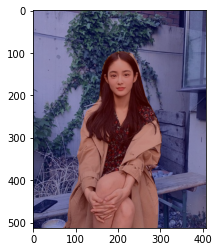

In [7]:
# 사진 중에서 사람의 라벨, 즉 15를 가진 영역만 검출해 봅시다.
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 4) 세그멘테이션 결과를 원래 크기로 복원하기

Original Size Mask: (563, 709)
DeepLab Model Mask: (513, 407)


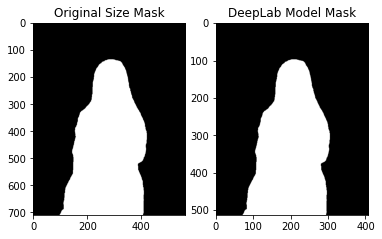

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'Original Size Mask: {img_orig.shape[:2][::-1]}\nDeepLab Model Mask: {img_mask.shape}')

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 5) 배경 흐리게 하기

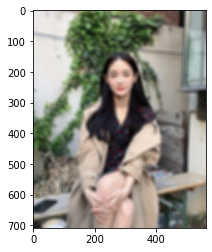

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 6) 흐려진 이미지에서 배경만 추출

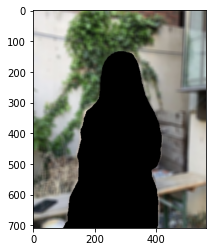

In [10]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출합니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 7) 흐린 배경과 원본 영상 합성

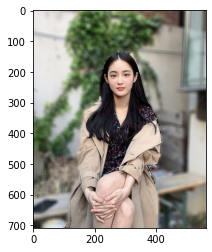

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 인물 크로마키 만들기

### 1) 배경 이미지 준비

In [12]:
newyork_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/new_york.png'
newyork_orig = cv2.imread(newyork_path) 
# 배경 이미지를 인물 이미지 사이즈와 동일하게 맞춰주기
newyork_orig = cv2.resize(newyork_orig, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

print("인물 이미지 사이즈: ", img_orig.shape)
print("인물 마스크 사이즈: ", img_mask_up.shape)
print("배경 이미지 사이즈: ", newyork_orig.shape)

인물 이미지 사이즈:  (709, 563, 3)
인물 마스크 사이즈:  (709, 563)
배경 이미지 사이즈:  (709, 563, 3)


### 2) 인물, 배경 이미지 확인

Text(0.5, 1.0, 'Origin Image')

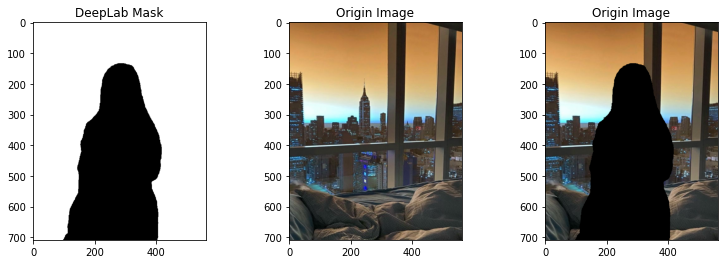

In [13]:
# 배경과 세그멘테이션 결과를 합성
newyork_bg = cv2.bitwise_and(newyork_orig, img_bg_mask)

fig = plt.figure(figsize=(13, 4)) 

ax = plt.subplot(1,3,1)
plt.imshow(img_bg_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Mask')

ax = plt.subplot(1,3,2)
plt.imshow(newyork_orig, cmap=plt.cm.binary_r)
ax.set_title('Origin Image')

ax = plt.subplot(1,3,3)
plt.imshow(newyork_bg, cmap=plt.cm.binary_r)
ax.set_title('Origin Image')

### 3) 원본 영상과 배경 합성

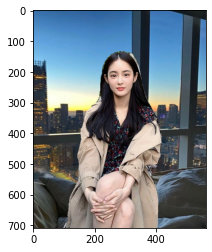

In [14]:
newyork_concat = np.where(img_bg_mask==0,img_orig, newyork_bg)

plt.imshow(cv2.cvtColor(newyork_concat,cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
plt.show()

## 3. 고양이 아웃포커싱

In [15]:
# 배경 불러오기
new_york_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/new_york.png'
new_york_orig = cv2.imread(new_york_path) 

print("이미지 마스크 사이즈: ", img_mask_up.shape)
print("배경 이미지 사이즈: ", new_york_orig.shape)

이미지 마스크 사이즈:  (709, 563)
배경 이미지 사이즈:  (818, 554, 3)


### 1) 이미지 준비

In [16]:
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'
cat_orig = cv2.imread(cat_path) 
print (cat_orig.shape)

(554, 563, 3)


In [17]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
cat_resized, cat_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, cat_map.max())

(554, 563, 3) (504, 513, 3) 8


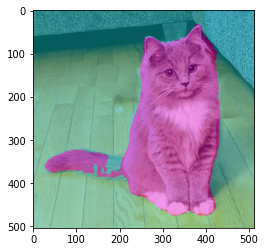

In [18]:
# 사진 중에서 고양이의 라벨, 즉 8를 가진 영역만 검출해 봅시다.
cat_show = cat_resized.copy()
cat_map = np.where(cat_map == 8, 8, 0) # 예측 중 고양이만 추출
cat_mask = cat_map * (255/cat_map.max()) # 255 normalization
cat_mask = cat_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_COOL)
cat_show = cv2.addWeighted(cat_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

### 2) 세그멘테이션 결과를 원래 크기로 복원하기

Original Size Mask: (563, 554)
DeepLab Model Mask: (504, 513)


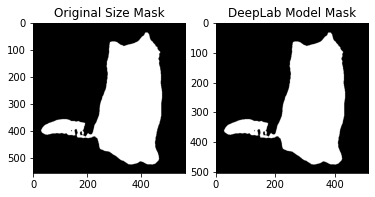

In [19]:
cat_mask_up = cv2.resize(cat_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'Original Size Mask: {cat_orig.shape[:2][::-1]}\nDeepLab Model Mask: {cat_mask.shape}')

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 3) 배경 흐리게 하기

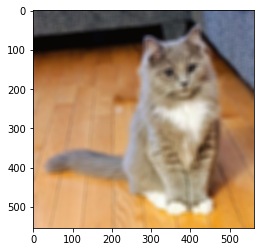

In [20]:
cat_orig_blur = cv2.blur(cat_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(cat_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 6) 흐려진 이미지에서 배경만 추출

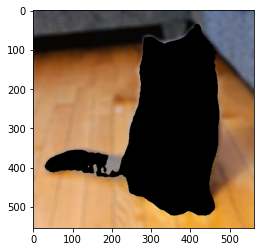

In [21]:
cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg_blur = cv2.bitwise_and(cat_orig_blur, cat_bg_mask)
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 7) 흐린 배경과 원본 영상 합성

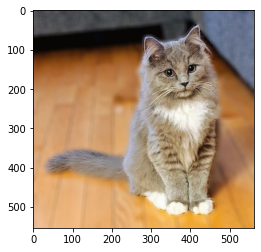

In [22]:
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)

plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 사진들의 문제점

#### * 인물 이외에 배경 일부분이 같이 마스킹 됨
(머리 오른쪽 위 흰색 벽)

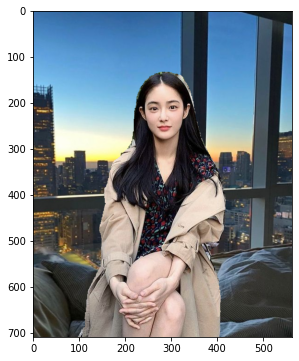

In [23]:
plt.figure(figsize=(16,6))
plt.imshow(cv2.cvtColor(newyork_concat, cv2.COLOR_BGR2RGB))

#### * 고양이의 꼬리 중앙 부분이 마스킹되지 못함

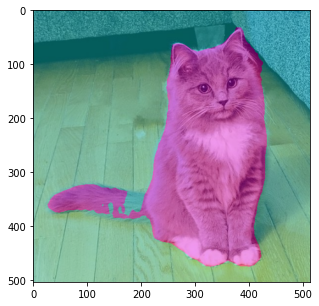

In [24]:
plt.figure(figsize=(5,5))

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 문제 해결 방법

#### * 문제 : 엣지 부분에서 레이블의 분할이 정확하지 않아 세세한 분할 정확도가 부족
#### * 원인 : 레이블 맵의 크기를 늘리는 과정에서 발생   
#### * 해결 방법 : 알고리즘의 목표는 에지 부분의 레이블을 수정하여 소폭의 정확도를 향상하는 것  

    1) 원본 영상을 학습시킨 신경망(Deeplab v3+)에 입력하여 결과물인 레이블 맵을 얻기     
    2) 원본 영상에 캐니 에지 검출기를 이용해 에지 맵을 추출(NYU Depth v2 데이터 셋)     
    3) 그 후 에지 맵과 레이블 맵이 후처리 알고리즘에 입력되고 후처리 알고리즘 수행을 시작 
          a) 오직 에지 픽셀에서만 탐색을 시작하고, 한 에지 픽셀은 8방향으로 전진하며 레이블 값을 수집     
          b) 탐색 때 저장한 레이블 값과 여러 정보를 바탕으로 현재 레이블을 유지할 것인지, 변경할 것인지 판단     
          c) 한 판단이 끝나면 해당 방향은 종료되어 다음 방향으로 탐색을 시작하고, 
             8방향 모두 탐색과 판단을 끝마치면 다음 에지 픽셀로 이동해 8방향의 탐색-판단 과정을 다시 반복    
#### * 결과 : NYU v2 데이터 셋 기준으로 약 1.74%p의 평균 픽셀 정확도 상승과 1.35%p의 IoU 정확도 상승    
[논문 참고] http://koreascience.or.kr/article/JAKO202112054772437.page     
(2021), 의미론적 영상 분할의 정확도 향상을 위한 에지 정보 기반 후처리 방법

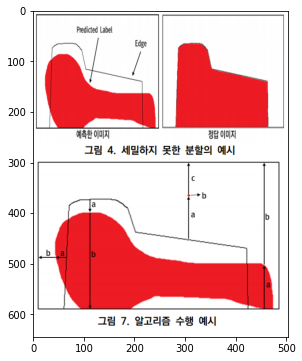

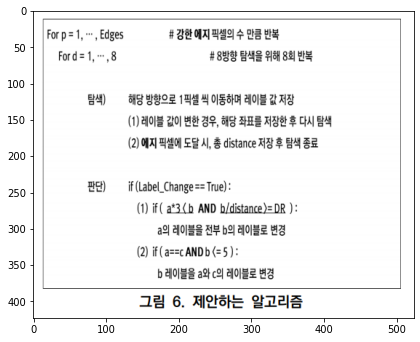

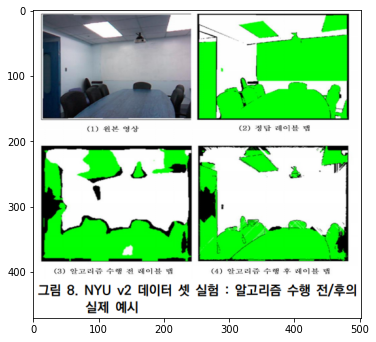

In [25]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/DeepLab/0.png'
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/DeepLab/2.png'
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/DeepLab/4.png'

img = cv2.imread(img_path)
img2 = cv2.imread(img_path2)
img3 = cv2.imread(img_path3)

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(15,15))
ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(20,20))
ax = plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

plt.show()